In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
features = pd.read_csv('./dataset/weather_data.csv')

features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,44,45.7,44,61
2,2016,1,3,Sun,45,45,45.8,44,56
3,2016,1,4,Mon,44,44,45.9,41,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [3]:
print(features.shape)

(20, 9)


In [5]:
import datetime

years = features["year"]
months = features["month"]
days = features["day"]

zipped = zip(years, months, days)
dates = [
    str(int(year)) + "-" + str(int(month)) + "-" + str(int(day))
    for year, month, day in zipped
]
dates = [
  datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates
]

In [6]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

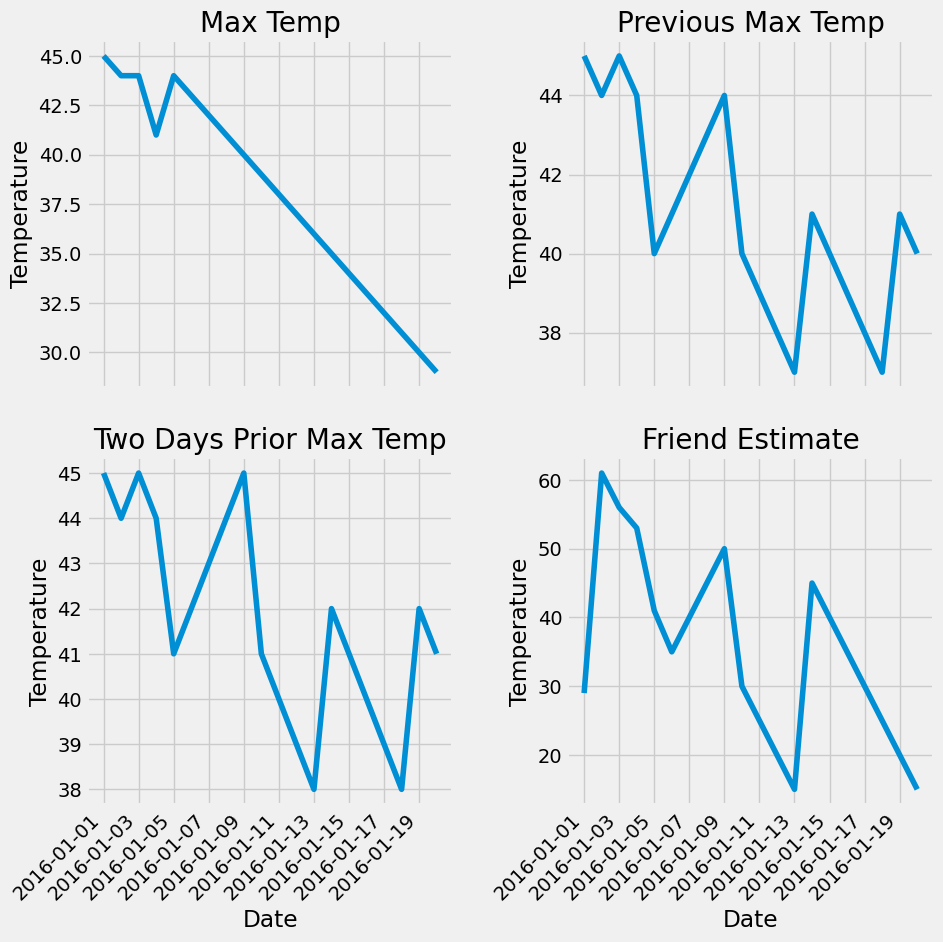

In [8]:
plt.style.use("fivethirtyeight")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features["actual"])
ax1.set_xlabel("")
ax1.set_ylabel("Temperature")
ax1.set_title("Max Temp")

# 昨天
ax2.plot(dates, features["temp_1"])
ax2.set_xlabel("")
ax2.set_ylabel("Temperature")
ax2.set_title("Previous Max Temp")

# 前天
ax3.plot(dates, features["temp_2"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Temperature")
ax3.set_title("Two Days Prior Max Temp")

# 朋友
ax4.plot(dates, features["friend"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Temperature")
ax4.set_title("Friend Estimate")

plt.tight_layout(pad=2)

In [9]:
# one hot encoding => week
features = pd.get_dummies(features)
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thu,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,44,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,45,45.8,44,56,False,False,False,True,False,False,False
3,2016,1,4,44,44,45.9,41,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [10]:
# lable target
labels = np.array(features["actual"])

# drop features
features = features.drop(["actual"], axis=1)

feature_list = list(features.columns)
features = np.array(features)


In [11]:
features.shape

(20, 14)

### standardize

In [12]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [13]:
input_features[0]

array([ 0.        ,  0.        , -1.64750894,  1.47433127,  1.63477706,
       -0.52522573, -0.49255147,  2.38047614, -0.42008403, -0.42008403,
       -0.42008403, -0.33333333, -0.42008403, -0.42008403])

### NN

In [14]:
x = torch.tensor(input_features, dtype=float)
y = torch.tensor(labels, dtype=float)

weigths = torch.randn((14, 128), dtype=float, requires_grad=True)
biases = torch.randn(128, dtype=float, requires_grad=True)
weigths2 = torch.randn((128, 1), dtype=float, requires_grad=True)
biases2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []


In [16]:
for i in range(1000):
    # 计算隐藏层
    hidden = x.mm(weigths) + biases
    # 激活函数
    hidden = torch.relu(hidden)
    # 计算输出层
    predicitions = hidden.mm(weigths2) + biases2
    # 计算损失
    loss = torch.mean((predicitions - y) ** 2)
    # 记录损失
    losses.append(loss.item())

    # 打印损失值
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item()}")

    # 反向传播
    loss.backward()

    # 更新权重和偏置
    weigths.data.add_(-learning_rate * weigths.grad.data)
    biases.data.add_(-learning_rate * biases.grad.data)
    weigths2.data.add_(-learning_rate * weigths2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)

    # 清空迭代
    weigths.grad.data.zero_()
    biases.grad.data.zero_()
    weigths2.grad.data.zero_()
    biases2.grad.data.zero_()

Epoch 0, Loss: 25.29
Epoch 100, Loss: 25.290000000000006
Epoch 200, Loss: 25.29
Epoch 300, Loss: 25.29
Epoch 400, Loss: 25.29
Epoch 500, Loss: 25.29
Epoch 600, Loss: 25.29
Epoch 700, Loss: 25.29
Epoch 800, Loss: 25.29
Epoch 900, Loss: 25.29


In [17]:
predicitions.shape

torch.Size([20, 1])

### NN - version 2

In [18]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(
  torch.nn.Linear(input_size, hidden_size),
  torch.nn.Sigmoid(),
  torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [19]:
losses = []
for i in range(1000):
    batch_loss = []

    for start in range(0, len(input_features), batch_size):
        # 获取一个批次
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)

        # 计算预测值
        predicitions = my_nn(xx)
        # 计算损失
        loss = cost(predicitions, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        # 记录损失
        batch_loss.append(loss.item())

    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(f"Epoch {i}, Loss: {np.mean(batch_loss)}")

Epoch 0, Loss: 1260.2872314453125
Epoch 100, Loss: 492.3590316772461
Epoch 200, Loss: 153.82887244224548
Epoch 300, Loss: 44.66611862182617
Epoch 400, Loss: 17.941172122955322
Epoch 500, Loss: 12.20021390914917
Epoch 600, Loss: 10.839656591415405
Epoch 700, Loss: 10.448395729064941
Epoch 800, Loss: 10.258133888244629
Epoch 900, Loss: 10.086972713470459


### Testing

In [22]:
x = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(x).data.numpy()

In [23]:
zipped = zip(years, months, days)
dates = [
    str(int(year)) + "-" + str(int(month)) + "-" + str(int(day))
    for year, month, day in zipped
]
dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]

true_data = pd.DataFrame(data={"date": dates, "actual": labels})

years = features[:, feature_list.index("year")]
months = features[:, feature_list.index("month")]
days = features[:, feature_list.index("day")]

test_dates = [
    str(int(year)) + "-" + str(int(month)) + "-" + str(int(day))
    for year, month, day in zipped
]
test_dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in test_dates]
predicitions_data = pd.DataFrame(data={"date": test_dates, "prediction": predict.reshape(-1)})

ValueError: All arrays must be of the same length

In [ ]:
plt.plot(true_data["date"], true_data["actual"], "b-", label="actual")

plt.plot(predicitions_data["date"], predicitions_data["prediction"], "ro-", label="prediction")
plt.xticks(rotation="60")
plt.legend()

plt.xlabel("Date")
plt.ylabel("Maximum Temperature(F)")
plt.title("Actual vs Predicted Maximum Temperature")